# Remove Redundant Data

In [1]:
import pandas as pd

# Reading a CSV file into a DataFrame, selecting specific columns
fields = ['item_description']
df = pd.read_csv('order_details_202505141508.csv', usecols=fields)

# use for loop to print first 10 rows of the DataFrame
for i in range(20):
    print(df.iloc[i].values[0])

Place Packing List Inside Box and Stamp Box
5 PIECES PER POLYBAG
Place Packing List Inside Box and Stamp Box
Place Packing List Inside Box and Stamp Box
50 EACH OF ITEM COLOR IN ONE BOX
Place Packing List Inside Box and Stamp Box
Place Packing List Inside Box and Stamp Box
Place Packing List Inside Box and Stamp Box
APPLY BARCODE LABELS TO EACH ITEM
5 PER POLYBAG
Place Packing List Inside Box and Stamp Box
Place Packing List Inside Box and Stamp Box
Place Packing List Inside Box and Stamp Box
Apply Fragile and Directional labels to all cartons.
Place Packing List Inside Box and Stamp Box
Special Package - POLYBAG ONE OF EACH COLOR
Place Packing List Inside Box and Stamp Box
Place Packing List Inside Box and Stamp Box	
Place Packing List Inside Box and Stamp Box
3 OF THE FEMALE & 3 OF THE MALE PHYSICIAN IN ONE POLY BAG


In [2]:
import re

print(df.shape)
print("\n\nAfter removing duplicates")
df['item_description'] = df['item_description'].str.lower() # there are lots of words with the same meaning but different cases
print(df.shape)

def clean_data(text):
    # apply number masking to reduce sensitivity to specific quantity values
    text = re.sub(r'\b\d+(\.\d+)?\b', '<NUM>', text)#\b means word boundary. \d+ means Match 1 or more digits
    # remove non-informative puncutuation
    text = re.sub(r'[-:*"\'.,]', '', text)
    # remove non-informative words
    text = re.sub(r'\b(please|kindly)\b', '', text) 
    # remove repeated spaces
    text = re.sub(r'\s+', ' ', text) # \s+ = one or more whitespace character
    # remove "special package"
    text = re.sub(r'\b(special package|special packaging)\b', '', text)
    # remove space at the beginning and end of the string
    text = text.strip()
    # remove "special package"
    text = re.sub(r'\b(special package|special packaging)\b', '', text)

    return text



df['item_description'] = df['item_description'].apply(clean_data)



# remove duplicates
df.drop_duplicates(inplace=True)
print(df.shape)

for i in range(20):
    print(df.iloc[i].values[0])

# turn it into a list
item_list = df['item_description'].tolist()
print(len(item_list))

(34938, 1)


After removing duplicates
(34938, 1)
(2833, 1)
place packing list inside box and stamp box
<NUM> pieces per polybag
<NUM> each of item color in one box
apply barcode labels to each item
<NUM> per polybag
apply fragile and directional labels to all cartons
polybag one of each color
<NUM> of the female & <NUM> of the male physician in one poly bag
<NUM> item per poly bag
boxes of <NUM>
<NUM> per box
packages of <NUM>
yellow msbcom labels to outside of all shipping cartons
<NUM> box assorted items
attach nfl hologram sticker
packs of <NUM>
<NUM> of each color per box
<NUM> of each color per box <NUM> full boxes
<NUM> per poly
<NUM> of each color <NUM> partial box
2833


# UMAP + HDBSCAN 

UMAP is often preferred for larger datasets or when maintaining both global and local patterns is crucial, while t-SNE might be used for finer cluster analysis in smaller datasets. PCA is generally faster and preferred for preliminary analysis or when the relationships in the data are primarily linear.
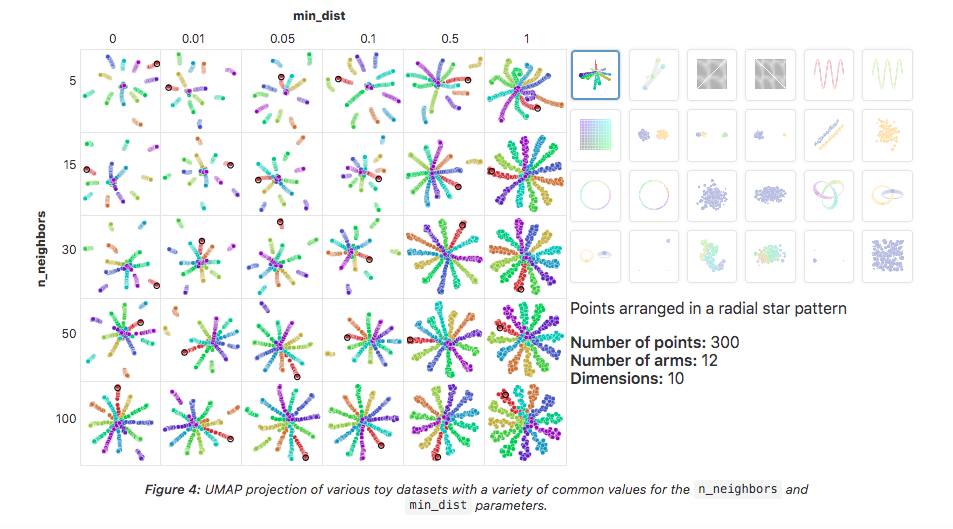

https://pair-code.github.io/understanding-umap/

In [3]:
from sentence_transformers import SentenceTransformer
import hdbscan
import umap
import matplotlib.pyplot as plt
import random
import numpy as np

# set the random seed for reproducibility
random.seed(33)                
np.random.seed(33)             

# load the model

model = SentenceTransformer('all-MiniLM-L6-v2') # this is a smaller model
# model = SentenceTransformer('all-mpnet-base-v2') # this is a larger model

# encode the sentences
SentenceTransformer_embeddings = model.encode(item_list, show_progress_bar=True)





Batches:   0%|          | 0/89 [00:00<?, ?it/s]

In [4]:
# reduce the dimensionality of the embeddings. 
# n_neighbors is the number of neighbors to consider when constructing the UMAP graph. For noisy data, larger n_neighbors may produce more stable embeddings.
# n_components is the number of dimensions to reduce to(output dimension). Use 2 for visulization purposes
reducer = umap.UMAP(n_neighbors=50, min_dist=0.0, n_components=15, metric='euclidean', random_state=33)
embeddings = reducer.fit_transform(SentenceTransformer_embeddings)

c:\Users\AlanC\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [5]:
# clustering the reduced embeddings
# for min_cluster_size, Smaller → more (and smaller) clusters, Larger → fewer, more robust clusters
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, cluster_selection_epsilon=0.3, metric='euclidean', prediction_data=True) 

# fit the HDBSCAN model to the reduced embeddings
clusterer.fit(embeddings)
# get the cluster labels
labels = clusterer.labels_

# Measures how similar an object is to its own cluster compared to other clusters.
# 0.70 – 1.00: Strong structure; well-separated clusters.
# 0.50 – 0.70: Reasonable structure; some overlapping clusters.
# 0.25 – 0.50: Weak structure; potential overlapping or incorrect clustering.
# Below 0.25: Poor structure; clustering may not be meaningful.
from sklearn.metrics import silhouette_score
score = silhouette_score(embeddings, labels)
print(f"Silhouette Score: {score:.3f}")

# Evaluates the average similarity between each cluster and its most similar one.
# < 0.5: Excellent
# 0.5 – 1.0: Acceptable
# > 1.0: Poorly separated clusters
from sklearn.metrics import davies_bouldin_score
dbi = davies_bouldin_score(embeddings, labels)
print(f"Davies-Bouldin Index: {dbi:.3f}")

# Assesses cluster dispersion; higher values suggest better-defined clusters.
# > 500: Often indicates well-separated clusters
# > 1000: Strong cluster separation (in many cases)
# Be cautious — it increases with number of clusters
from sklearn.metrics import calinski_harabasz_score
chi = calinski_harabasz_score(embeddings, labels)
print(f"Calinski-Harabasz Index: {chi:.3f}")

# small model n_neighbors=50, min_dist=0.0, n_components=15, metric='cosine'
# Silhouette Score: 0.510
# Davies-Bouldin Index: 0.954
# Calinski-Harabasz Index: 1591.978


# clusterer = hdbscan.HDBSCAN(min_cluster_size=15, cluster_selection_epsilon=0.1, metric='euclidean', prediction_data=True) 
# Silhouette Score: 0.500
# Davies-Bouldin Index: 0.957
# Calinski-Harabasz Index: 2168.214

# min_cluster_size=15, cluster_selection_epsilon=0.3, metric='euclidean', prediction_data=True
# Silhouette Score: 0.529
# Davies-Bouldin Index: 0.887
# Calinski-Harabasz Index: 3401.841


Silhouette Score: 0.529
Davies-Bouldin Index: 0.887
Calinski-Harabasz Index: 3401.841


In [6]:
import random
from collections import defaultdict

# for reproducibility
random.seed(42)  

# Create a dictionary to hold sentences by cluster
cluster_dict = defaultdict(list)

# Fill the dictionary
for label, sentence in zip(clusterer.labels_, item_list):
    cluster_dict[label].append(sentence)

# Display a few clusters
for label in sorted(cluster_dict.keys()):
    print(f"\n=== Cluster {label} ===")
    cluster = cluster_dict[label]

    # randomly select 5 sentences from the cluster
    sample_size = min(20, len(cluster))
    sample = random.sample(cluster, sample_size) 
    
    for sentence in sample:
        print(f"{sentence}")
    if len(cluster) > 20:
        print(f"...and {len(cluster) - 20} more\n")


=== Cluster -1 ===
sku <NUM><NUM> printed placed lower right corner
reship order
<NUM> clear paks & <NUM> red paks per polybag (<NUM> total per bag)
rush fee from ach for early ship date
<NUM> balls per big bag
each design need to be packaged seperately
ship in <NUM> total boxes <NUM> in each box
<NUM> pieces blank
pls send sample tumbler back to customer once order completed
in sets of <NUM>
add supplied tag
all packed in zbamr21
packaged in bags of <NUM>
pack securely in shipping box
core <NUM> jackets see spreadsheet male xl
choke hazard warning

<NUM> pcs in one poly
switch out the bottoms with po <NUM>
one of <NUM>)
...and 368 more


=== Cluster 0 ===
print bilingual instructions on polybag wkaom15rd
print bilingual instructions on polybag
print bilingual instructions on polybag wpchs20bk
print bilingual instructions on polybag wpchq15wh
print bilingual instructions on polybag whfbd10cl
print bilingual instructions on polybag whfbd10gn
print bilingual instructions on polybag wpch

# Visualization 

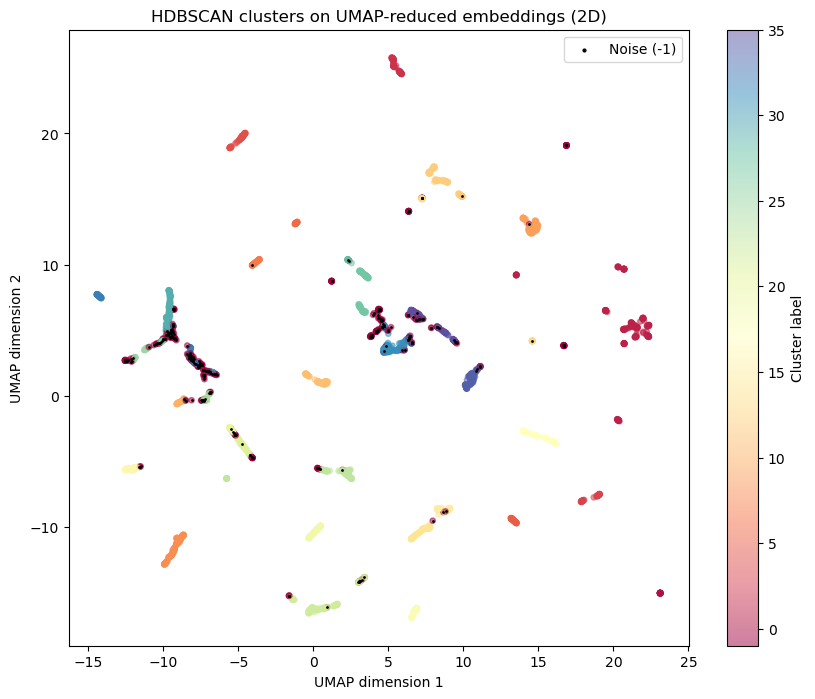

In [129]:
import umap
import matplotlib.pyplot as plt

# 1. Re‑embed into 2D for visualization
reducer_2d = umap.UMAP(
    n_neighbors=30,
    n_components=2,
    metric='cosine',
    random_state=42
)
embeds_2d = reducer_2d.fit_transform(embeddings)  # embeddings from your SentenceTransformer step

# 2. Scatter‑plot clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embeds_2d[:, 0],
    embeds_2d[:, 1],
    c=labels,                  # labels from HDBSCAN
    cmap='Spectral',           # nice categorical palette
    s=15,                       # point size
    alpha=0.5                  
)
plt.colorbar(scatter, label='Cluster label')
plt.title('HDBSCAN clusters on UMAP-reduced embeddings (2D)')
plt.xlabel('UMAP dimension 1')
plt.ylabel('UMAP dimension 2')

# 3. Optional: highlight noise points
noise_mask = labels == -1
plt.scatter(
    embeds_2d[noise_mask, 0],
    embeds_2d[noise_mask, 1],
    # show noise points in transparent
    # alpha=0, # comment out to see them
    c='black',
    s=1,
    label='Noise (-1)'
)
plt.legend(markerscale=2, frameon=True)
plt.show()


# Save the Model

In [7]:
import joblib

# Save UMAP reducer and HDBSCAN clusterer
joblib.dump(reducer, 'my_umap_reducer_fianl.pkl')
joblib.dump(clusterer, 'my_hdbscan_clusterer_final.pkl')

['my_hdbscan_clusterer_final.pkl']

# HyperParameter Tuning

In [ ]:
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
import random
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import ParameterGrid

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import pandas as pd

# Reading a CSV file into a DataFrame, selecting specific columns
fields = ['item_description']
df = pd.read_csv('order_details_202505141508.csv', usecols=fields)

# use for loop to print first 10 rows of the DataFrame
for i in range(20):
    print(df.iloc[i].values[0])

import re

print(df.shape)
print("\n\nAfter removing duplicates")
df['item_description'] = df['item_description'].str.lower() # there are lots of words with the same meaning but different cases
print(df.shape)

def clean_data(text):
    # apply number masking to reduce sensitivity to specific quantity values
    text = re.sub(r'\b\d+(\.\d+)?\b', '<NUM>', text)#\b means word boundary. \d+ means Match 1 or more digits
    # remove non-informative puncutuation
    text = re.sub(r'[-:*"\'.,]', '', text)
    # remove non-informative words
    text = re.sub(r'\b(please|kindly)\b', '', text) 
    # remove repeated spaces
    text = re.sub(r'\s+', ' ', text) # \s+ = one or more whitespace character
    # remove "special package"
    text = re.sub(r'\b(special package|special packaging)\b', '', text)
    # remove space at the beginning and end of the string
    text = text.strip()
    # remove "special package"
    text = re.sub(r'\b(special package|special packaging)\b', '', text)

    return text



df['item_description'] = df['item_description'].apply(clean_data)



# remove duplicates
df.drop_duplicates(inplace=True)
print(df.shape)

for i in range(20):
    print(df.iloc[i].values[0])

# turn it into a list
item_list = df['item_description'].tolist()
print(len(item_list))

grid = {
    "n_neighbors": [25, 50, 75, 100, 150, 200],
    "min_dist": [0.0, 0.1, 0.2, 0.3],
    "n_components": [2, 5, 10, 15, 20, 25, 30],
    "Umetric": ['euclidean', 'manhattan', 'cosine'],
    "min_samples": [5, 10, 15, 20, 25, 30],
    "min_cluster_size": [5, 10, 15, 20, 25, 30],
    "cluster_selection_epsilon": [0.0, 0.1, 0.2, 0.3],
    "Hmetric": ['euclidean', 'manhattan'],
}

# test only
# grid = {
#     "n_neighbors": [25, 50],
#     "min_dist": [0.3],
#     "n_components": [2, 5],
#     "Umetric": ['euclidean'],
#     "min_samples": [10],
#     "min_cluster_size": [5, 10],
#     "cluster_selection_epsilon": [0.1],
#     "Hmetric": ['euclidean'],
# }

random_seeds = [33, 34, 35]  
models = ['all-MiniLM-L6-v2', 'all-mpnet-base-v2']

results = []

for model_name in models:
    model = SentenceTransformer(model_name)
    orig_emb = model.encode(item_list, show_progress_bar=True)

    for params in ParameterGrid(grid):
        silhouettes, dbis, chis = [], [], []

        for seed in random_seeds:
            random.seed(seed)
            np.random.seed(seed)

            # UMAP on the original embeddings
            reducer = umap.UMAP(
                n_neighbors=params['n_neighbors'],
                min_dist=params['min_dist'],
                n_components=params['n_components'],
                metric=params['Umetric'],
                random_state=seed
            )
            emb2d = reducer.fit_transform(orig_emb)

            # HDBSCAN clustering
            clusterer = hdbscan.HDBSCAN(
                min_samples=params['min_samples'],
                min_cluster_size=params['min_cluster_size'],
                cluster_selection_epsilon=params['cluster_selection_epsilon'],
                metric=params['Hmetric'],
                prediction_data=True
            )
            clusterer.fit(emb2d)
            labels = clusterer.labels_

            # skip trivial clusterings
            if len(set(labels)) < 2 or (labels == -1).all():
                # Skip or assign a sentinel score
                continue

            silhouettes.append(silhouette_score(emb2d, labels))
            dbis.append(davies_bouldin_score(emb2d, labels))
            chis.append(calinski_harabasz_score(emb2d, labels))

        if silhouettes:  # at least one valid run
            results.append({
                **params,
                "model": model_name,
                "silhouette": np.mean(silhouettes),
                "dbi": np.mean(dbis),
                "chi": np.mean(chis),
            })

# Turn into DataFrame for easy sorting/filtering
df = pd.DataFrame(results)

# Find best by silhouette
best = df.sort_values("silhouette", ascending=False).iloc[0]
print("Best configuration (by silhouette):")
print(best)

df.to_csv("umap_hdbscan_hyperparam_results.csv", index=False)

Batches:   0%|          | 0/89 [00:00<?, ?it/s]

Best configuration (by silhouette):
Hmetric                             euclidean
Umetric                             euclidean
cluster_selection_epsilon                 0.1
min_cluster_size                            5
min_dist                                  0.3
min_samples                                10
n_components                                5
n_neighbors                                25
model                        all-MiniLM-L6-v2
silhouette                            0.32321
dbi                                   0.87178
chi                                638.421933
Name: 2, dtype: object
